In [1]:
import json
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
file_image_example = '../data/train/images/16_1554808647_858_nong_2019_yamaha_freego_ve_viet_nam_gia_tu_3299_trieu_dong_ya2_1554807803_width660height440_1568719059157_6926_jpg.rf.80c2a021fab889abf78cf7941d0154c0.jpg'

img = cv2.imread(file_image_example)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))
plt.imshow(img)

In [4]:
file_labels_example = '../data/train/labels/16_1554808647_858_nong_2019_yamaha_freego_ve_viet_nam_gia_tu_3299_trieu_dong_ya2_1554807803_width660height440_1568719059157_6926_jpg.rf.80c2a021fab889abf78cf7941d0154c0.txt'

with open(file_labels_example) as f:
    lines_txt = f.readlines()
    lines = []
    for line in lines_txt:
        lines.append([int(line.split()[0])] + [round(float(el), 7) for el in line.split()[1:]])

for idx, line in enumerate(lines):
    print("Rectangle {}:".format(idx+1), line)

Rectangle 1: [0, 0.5313425, 0.4933529, 0.8644819, 0.9867058]
Rectangle 2: [1, 0.394563, 0.1998894, 0.1558414, 0.1140611]
Rectangle 3: [2, 0.8600037, 0.3621855, 0.104432, 0.1222528]


In [3]:
keypoint_names = ['Head', 'Tail']

# Dictionary to convert rectangles classes into keypoint classes because keypoint classes should start with 0
rectangles2keypoints = {1:0, 2:1}

def converter(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]
    
    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes.
        if line[0] == 0:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints.
        # After convertion, numbers of keypoint classes should start with 0, so we apply rectangles2keypoints dictionary to achieve that.
        # In our case:
        # 1 is rectangle for head keypoint, which is 0, so we convert 1 to 0;
        # 2 is rectangle for tail keypoint, which is 1, so we convert 2 to 1.
        if line[0] != 0:
            kp_id, x_c, y_c = rectangles2keypoints[line[0]], round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are matching keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                
    return bboxes, keypoints_sorted

In [ ]:
bboxes, keypoints_sorted = converter(file_labels_example, file_image_example, keypoint_names)

print("Bboxes:", bboxes)
print("Keypoints:", keypoints_sorted)

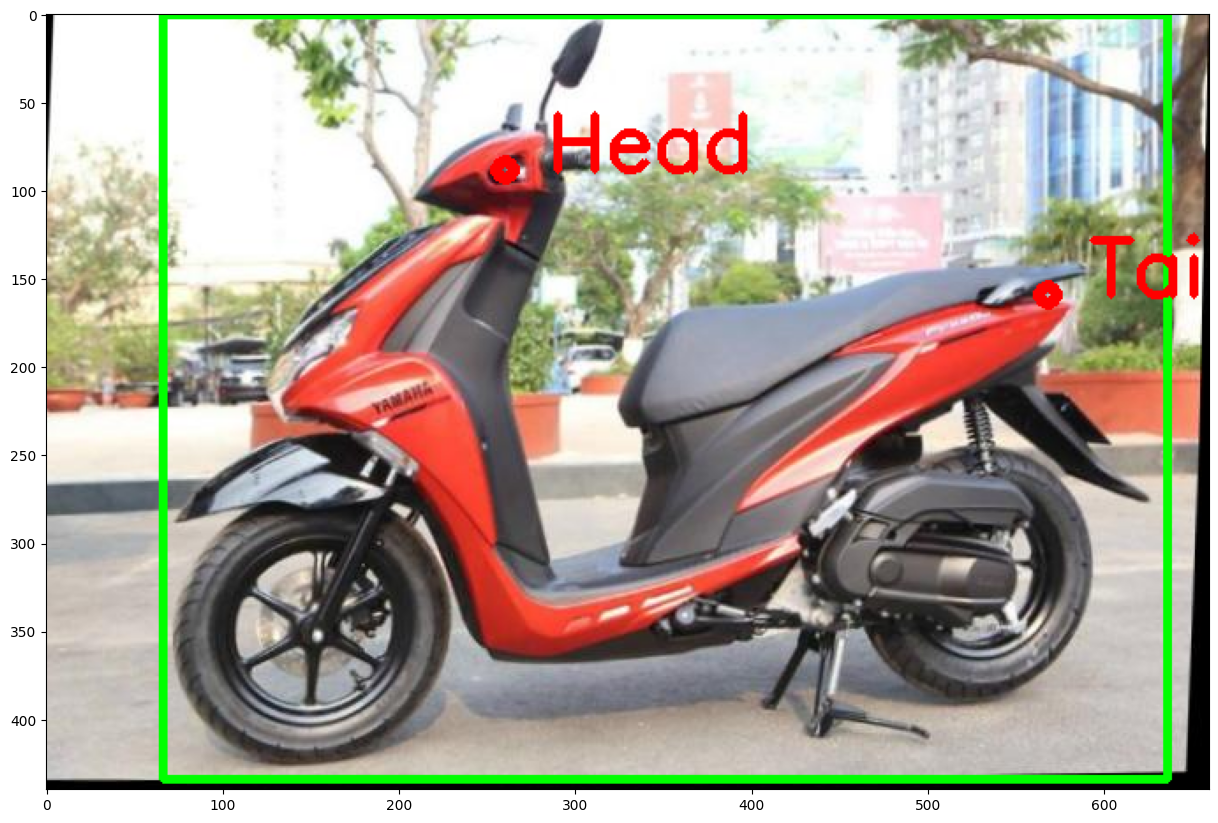

In [7]:
for bbox_idx, bbox in enumerate(bboxes):
    top_left_corner, bottom_right_corner = tuple([bbox[0], bbox[1]]), tuple([bbox[2], bbox[3]])
    img = cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,255,0), 3)
    
    for kp_idx, kp in enumerate(keypoints_sorted[bbox_idx]):
        center = tuple([kp[0], kp[1]])
        img = cv2.circle(img, center, 5, (255,0,0), 5)
        img = cv2.putText(img, " " + keypoint_names[kp_idx], center, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
        
plt.figure(figsize=(15,15))
plt.imshow(img)

In [6]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

In [10]:
IMAGES = '../data/train/images'
LABELS = '../data/train/labels'
ANNOTATIONS = '../data/train/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    print("Processing", file_labels, file_image)
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

Processing ../data/train/labels\0422_1568719758691_16667_jpg.rf.053c14e4cca72627f61407b52d2c9304.txt ../data/train/images\0422_1568719758691_16667_jpg.rf.053c14e4cca72627f61407b52d2c9304.jpg
Processing ../data/train/labels\0422_1568719758691_16667_jpg.rf.c885201359cd6d1e0cb408b043fcf8fa.txt ../data/train/images\0422_1568719758691_16667_jpg.rf.c885201359cd6d1e0cb408b043fcf8fa.jpg
Processing ../data/train/labels\0422_1568719758691_16667_jpg.rf.df7ba0c132ab72a25bbfd3e9def24fd2.txt ../data/train/images\0422_1568719758691_16667_jpg.rf.df7ba0c132ab72a25bbfd3e9def24fd2.jpg
Processing ../data/train/labels\0517_1568719764629_16747_jpg.rf.351acf7d3341cdfc57e13f2b1e87de8c.txt ../data/train/images\0517_1568719764629_16747_jpg.rf.351acf7d3341cdfc57e13f2b1e87de8c.jpg
Processing ../data/train/labels\0517_1568719764629_16747_jpg.rf.686ec14a86ead2ba6b2dcc6adfe99253.txt ../data/train/images\0517_1568719764629_16747_jpg.rf.686ec14a86ead2ba6b2dcc6adfe99253.jpg
Processing ../data/train/labels\0517_15687197

In [11]:
IMAGES = '../data/test/images'
LABELS = '../data/test/labels'
ANNOTATIONS = '../data/test/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    print("Processing", file_labels, file_image)
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

Processing ../data/test/labels\10_sym_angela_1_1568719338028_10801_jpg.rf.4ef956e0edb66db664048083adcd4882.txt ../data/test/images\10_sym_angela_1_1568719338028_10801_jpg.rf.4ef956e0edb66db664048083adcd4882.jpg
Processing ../data/test/labels\20_xe_lead_2017_9_1568719024115_6431_jpg.rf.2d62991452e1067505e24e0881e1c51a.txt ../data/test/images\20_xe_lead_2017_9_1568719024115_6431_jpg.rf.2d62991452e1067505e24e0881e1c51a.jpg
Processing ../data/test/labels\36_honda_future_2017_5_1568719701085_15859_jpg.rf.b21bed5aadc9868baf24b2da2eedcd22.txt ../data/test/images\36_honda_future_2017_5_1568719701085_15859_jpg.rf.b21bed5aadc9868baf24b2da2eedcd22.jpg
Processing ../data/test/labels\5_wvn_05c0a17b5562979_54543651_1568719035196_6587_jpg.rf.e0dc1d7be154fc47a21a43b0bec4d7fc.txt ../data/test/images\5_wvn_05c0a17b5562979_54543651_1568719035196_6587_jpg.rf.e0dc1d7be154fc47a21a43b0bec4d7fc.jpg
Processing ../data/test/labels\62_xe_may_dien_osakar_gogo701_1568719170142_8484_jpg.rf.546668120322474b56578291c

In [12]:
IMAGES = '../data/valid/images'
LABELS = '../data/valid/labels'
ANNOTATIONS = '../data/valid/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    print("Processing", file_labels, file_image)
    bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

Processing ../data/valid/labels\29_4226b30714764f9bbcd000d144786e92_1568719436189_12179_jpg.rf.41c27b91678af47df8d1bfa2ae8fa69d.txt ../data/valid/images\29_4226b30714764f9bbcd000d144786e92_1568719436189_12179_jpg.rf.41c27b91678af47df8d1bfa2ae8fa69d.jpg
Processing ../data/valid/labels\3_xe_may_dien_yamaha_metis_gt169_1568719177094_8568_jpg.rf.ff6a4dc1799c47eb9fb7200b064ccb1f.txt ../data/valid/images\3_xe_may_dien_yamaha_metis_gt169_1568719177094_8568_jpg.rf.ff6a4dc1799c47eb9fb7200b064ccb1f.jpg
Processing ../data/valid/labels\61_9774525183_1568719715619_16068_jpg.rf.88d705ffea249af866528ffaf00dfc9f.txt ../data/valid/images\61_9774525183_1568719715619_16068_jpg.rf.88d705ffea249af866528ffaf00dfc9f.jpg
Processing ../data/valid/labels\7_1562283564_vatgia2_picture3181_1568719049145_6788_jpg.rf.3fd6f4bec9ccc0324b1477062578cf4b.txt ../data/valid/images\7_1562283564_vatgia2_picture3181_1568719049145_6788_jpg.rf.3fd6f4bec9ccc0324b1477062578cf4b.jpg
Processing ../data/valid/labels\89_mua_xe_may_na